Training dataset size : 5184 samples.
Validation dataset size : 98496 samples.
torch.Size([16000]) torch.Size([16000])


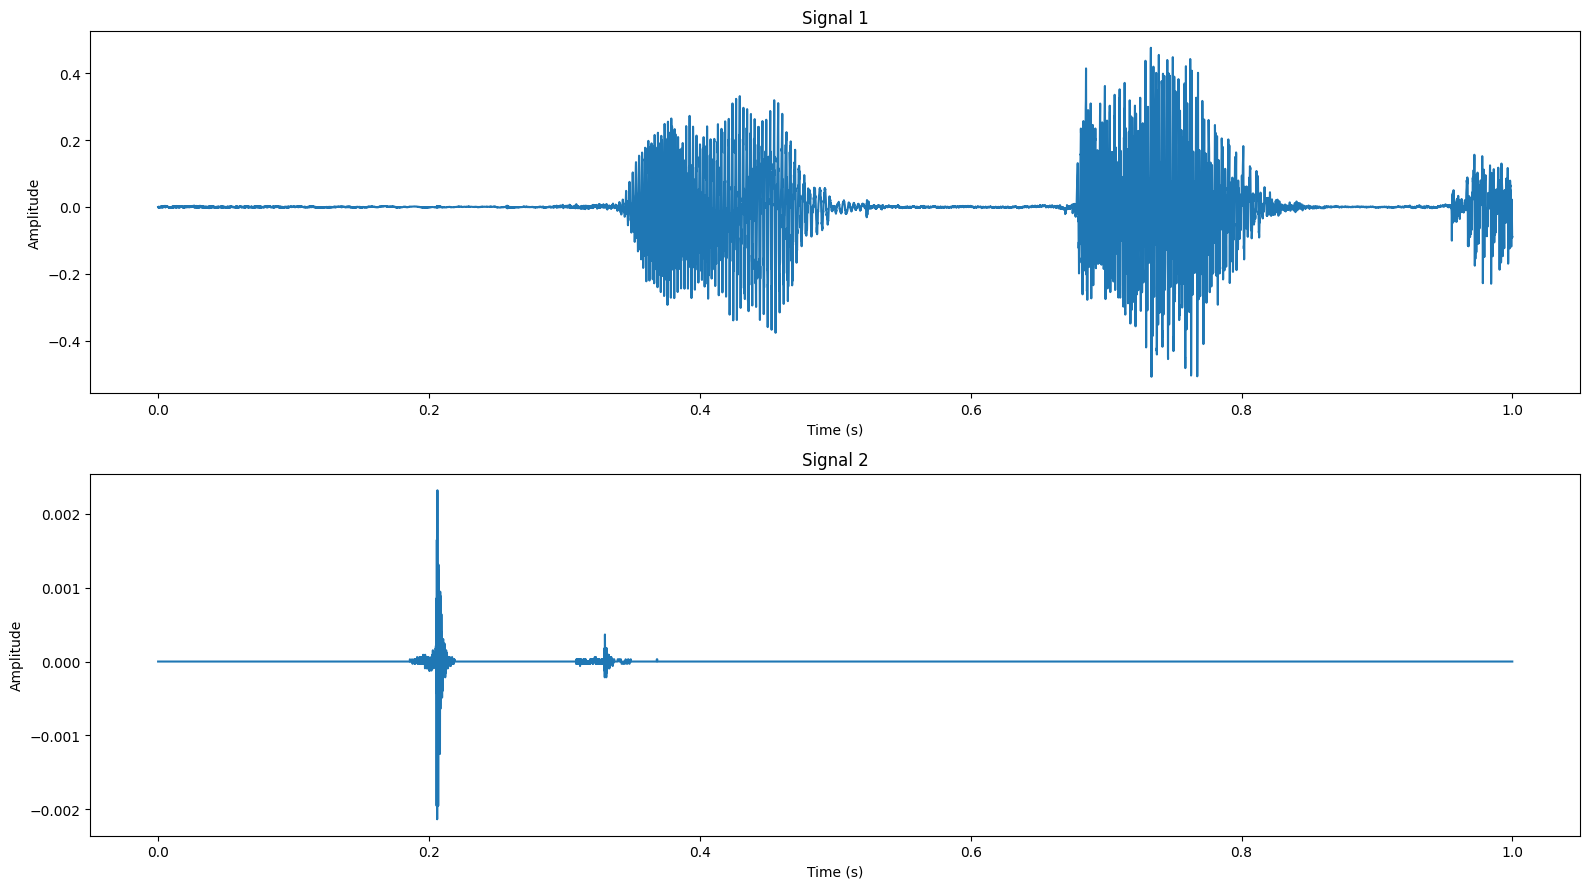

In [56]:
import os

import soundfile
import torch
from torch.utils.data import Dataset

from helpers import plot_2signals


def __getcleanaudio__(noisy_audio_file):
    parts = noisy_audio_file.split("_")
    first_part = "".join([part + "_" for part in parts[:-1]])[:-1]
    return first_part + ".flac"


class CustomAudioDataset(Dataset):
    def __init__(
        self,
        clean_audio_files,
        noisy_audio_files,
        clean_audio_files_dir,
        noisy_audio_files_dir,
        transform=None,
        target_transform=None,
        samplerate=16000,
    ):
        self.transform = transform
        self.target_transform = target_transform
        self.noisy_audio_files = noisy_audio_files
        self.clean_audio_files = clean_audio_files
        self.clean_audio_dir = clean_audio_files_dir
        self.noisy_audio_dir = noisy_audio_files_dir
        self.samplerate = samplerate

    def __len__(self):
        return len(self.noisy_audio_files)

    def __getitem__(self, idx):
        noisy_audio_file = os.path.join(noisy_audio_dir, self.noisy_audio_files[idx])
        noisy_audio, _ = soundfile.read(noisy_audio_file)
        clean_audio_file = os.path.join(
            self.clean_audio_dir, self.noisy_audio_files[idx].split("_")[0] + ".flac"
        )
        clean_audio, _ = soundfile.read(clean_audio_file)
        clean_audio = torch.tensor(clean_audio, dtype=torch.float32)
        noisy_audio = torch.tensor(noisy_audio, dtype=torch.float32)
        if self.transform:
            noisy_audio = self.transform(noisy_audio)
            clean_audio = self.transform(clean_audio)
        return noisy_audio, clean_audio


noisy_audio_dir = "preprocessed/train/noisy_audio"
noisy_audio_files = os.listdir(noisy_audio_dir)

clean_audio_dir = "preprocessed/train/clean_audio"
clean_audio_files = os.listdir(clean_audio_dir)

# clean_aduios_files = [os.path.join(clean_audios_dir, file) for file in clean_aduios_files]

validation_split = 0.95
training_split = 1 - validation_split

train_noisy_audio_files = noisy_audio_files[
    : int(training_split * len(noisy_audio_files))
]
train_clean_audio_files = clean_audio_files[
    : int(training_split * len(clean_audio_files))
]

val_noisy_audio_files = noisy_audio_files[
    int(training_split * len(noisy_audio_files)) :
]
val_clean_audio_files = clean_audio_files[
    int(training_split * len(clean_audio_files)) :
]

train_dataset = CustomAudioDataset(
    clean_audio_files=train_clean_audio_files,
    noisy_audio_files=train_noisy_audio_files,
    clean_audio_files_dir=clean_audio_dir,
    noisy_audio_files_dir=noisy_audio_dir,
)
print(f"Training dataset size : {len(train_dataset)} samples.")

val_dataset = CustomAudioDataset(
    clean_audio_files=val_clean_audio_files,
    noisy_audio_files=val_noisy_audio_files,
    clean_audio_files_dir=clean_audio_dir,
    noisy_audio_files_dir=noisy_audio_dir,
)
print(f"Validation dataset size : {len(val_dataset)} samples.")

noisy_audio, clean_audio = train_dataset[1234]
print(noisy_audio.shape, clean_audio.shape)
plot_2signals(noisy_audio, noisy_audio - clean_audio, 16000)


In [61]:
batch_size = 16
validation_split = 0.2
shuffle_dataset = True
random_seed = 42

training_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=shuffle_dataset
)
validation_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=shuffle_dataset
)

for noisy_audio, clean_audio in training_dataloader:
    print(noisy_audio.shape, clean_audio.shape)
    break


torch.Size([16, 16000]) torch.Size([16, 16000])


In [69]:
import torch
from torch import nn, relu, reshape
from torch.nn import Module
from torch.nn.modules.loss import _Loss as Loss
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :,:16000]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1),
            nn.AvgPool1d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1),
            nn.AvgPool1d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1),
            nn.AvgPool1d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1),
            nn.AvgPool1d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1),
            nn.AvgPool1d(kernel_size=2, stride=2),
            # Output shape = 8x498
            nn.Flatten(),
            # Output shape = 3984
            nn.Linear(3984, 1024),
        )

        self.decoder = nn.Sequential(
            nn.Linear(1024, 3984),
            Reshape(-1, 8, 498),
            # Block 1
            nn.ConvTranspose1d(in_channels=8, out_channels=8, kernel_size=3),
            nn.Upsample(scale_factor=2),
            # Block 2
            nn.ConvTranspose1d(in_channels=8, out_channels=8, kernel_size=3),
            nn.Upsample(scale_factor=2),
            # Block 3
            nn.ConvTranspose1d(in_channels=8, out_channels=8, kernel_size=3),
            nn.Upsample(scale_factor=2),
            # Block 4
            nn.ConvTranspose1d(in_channels=8, out_channels=8, kernel_size=3),
            nn.Upsample(scale_factor=2),
            # Block 5
            nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=3),
            nn.Upsample(scale_factor=2),
            Trim(),
        )

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = AutoEncoder()
x = torch.randn((16,1, 16000))
print(f"Input shape : {x.shape}")
out = model.encoder(x)
print(f"Encoder output shape : {out.shape}")
out = model.decoder(out)
print(f"Decoder output shape : {out.shape}")

Input shape : torch.Size([16, 1, 16000])
Encoder output shape : torch.Size([16, 1024])
Decoder output shape : torch.Size([16, 1, 16000])


In [70]:
def train_loop(
    dataloader: DataLoader, model: Module, loss_fn: Loss, optimizer: Optimizer
):
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.unsqueeze(1)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size * len(X)
            print(f"loss : {loss:>7f} [current : {current:>5d}/{size:>5d}]")


def validation_loop(dataloader: DataLoader, model: Module, loss_fn: Loss):
    # Set the model to evaluation mode
    model.eval()
    num_batches = len(dataloader)
    val_loss = 0
    # Compute loss over validation set
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
    val_loss = val_loss / num_batches
    print(f"validation_loss : {val_loss:>7f}")


model = AutoEncoder()
learning_rate = 0.001
epochs = 5
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(training_dataloader, model, loss_fn, optimizer)
    validation_loop(validation_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss : 0.104031 [current :     0/ 5184]


KeyboardInterrupt: 